<a href="https://colab.research.google.com/github/HiraiG/zerotsuku_5_academix/blob/main/8%E5%9B%9E/%E6%8B%A1%E6%95%A3%E3%83%A2%E3%83%87%E3%83%AB%E5%8B%89%E5%BC%B7%E4%BC%9A_VQ_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 拡散モデル勉強会（おまけ）

### 必要ライブラリのインポート

In [1]:
%matplotlib inline
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from typing import Tuple

from tqdm.notebook import tqdm


### NVIDIA GPU の状況確認

In [2]:
!nvidia-smi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nGPUの有無 :",device)

Sat Aug 24 05:36:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 乱数シードの固定

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    # torch.backends.cudnn.benchmark = False
    # torch.backends.cudnn.deterministic = True

set_seed(seed = 42 )

### データの読み込み（CIFAR10）

In [4]:
# transform = transforms.Compose(
#     [
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
#     ]
# )

# train_dataset = datasets.CIFAR10(
#     './data/CIFAR10', train=True, download=True, transform=transform
# )
# valid_dataset = datasets.CIFAR10(
#     './data/CIFAR10', train=False, download=True, transform=transform
# )

# data_variance = np.var(train_dataset.data / 255.0)

# train_loader = torch.utils.data.DataLoader(
#     train_dataset, batch_size=batch_size, shuffle=True
# )
# valid_loader = torch.utils.data.DataLoader(
#     valid_dataset, batch_size=batch_size, shuffle=False
# )

batch_size = 32

# datasets
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(torch.flatten) # falatten
            ])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15232975.81it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 509095.43it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4395152.67it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9906671.23it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## [復習] VAE の実装

### エンコーダ

In [5]:
class Encoder(nn.Module):
    """
    VAE のエンコーダ部分

    input_dim : 入力画像
    hidden_dim : 隠れ層の次元
    latent_dim : 潜在変数の次元
    mu : 平均
    sigma : 標準偏差
    """
    def __init__(self,
                 input_dim,
                 hidden_dim,
                 latent_dim
    ):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = self.linear(x)
        h = F.relu(h)
        mu = self.linear_mu(h)
        logvar = self.linear_logvar(h)
        sigma = torch.exp(0.5 * logvar)
        return mu, sigma

### デコーダ

In [6]:
class Decoder(nn.Module):
    """
    VAE のデコーダ部分

    latent_dim : 潜在変数の次元
    hidden_dim : 隠れ層の次元
    output_dim : 出力画像の次元
    x_hat : 出力画像
    """
    def __init__(self,
                 latent_dim,
                 hidden_dim,
                 output_dim
    ):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        x_hat = F.sigmoid(h)
        return x_hat

### 再パラメータ化トリック

In [7]:
def reparameterize(mu, sigma):
    """
    再パラメータ化トリック（reparametrization trick）
    z = μ + ε * σ
    """
    eps = torch.randn_like(sigma)
    z = mu + eps * sigma
    return z

### VAEの実装

In [8]:
class VAE(nn.Module):
    """
    VAE（変分オートエンコーダ）モデル

    input_dim : 入力画像の次元
    hidden_dim : 隠れ層の次元
    latent_dim : 潜在変数の次元
    かえり値
    loss : 負のELBO（損失関数）
    """
    def __init__(self,
                 input_dim,
                 hidden_dim,
                 latent_dim
    ):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def get_loss(self, x):
        """
        L1 : 再構成化誤差
        L2 : KLダイバージェンス
        """
        mu, sigma = self.encoder(x)
        z = reparameterize(mu, sigma)
        x_hat = self.decoder(z)

        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = - torch.sum(1 + torch.log(sigma ** 2) - mu ** 2 - sigma ** 2)
        return (L1 + L2) / batch_size

### ハイパーパラメータ

In [9]:
# hyperparameters
input_dim = 784  # x dimension（28×28）
hidden_dim = 200  # neurons in hidden layers
latent_dim = 10  # z dimension
epochs = 1
learning_rate = 3e-4

### モデルの学習

In [10]:
model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []

for epoch in tqdm(range(epochs), total=epochs):
    loss_sum = 0.0
    cnt = 0

    for x, _ in dataloader:
        x = x.view(x.size(0), -1) # Flatten and move to device
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    print(f"Epoch {epoch+1}, 負のELBO（損失関数）: {loss_avg:.4f}")
    losses.append(loss_avg)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, 負のELBO（損失関数）: 52.8203


### 学習結果の可視化

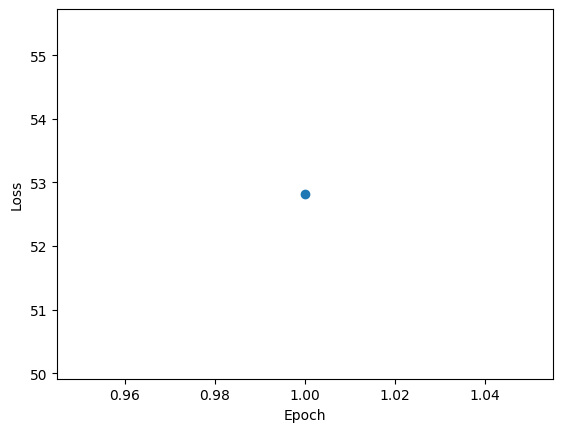

In [11]:
# plot losses
epochs_2 = list(range(1, epochs + 1))
plt.plot(epochs_2, losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

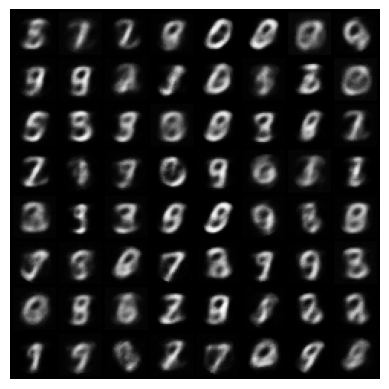

In [12]:
# generate new images
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, latent_dim)
    x = model.decoder(z)
    generated_images = x.view(sample_size, 1, 28, 28)

grid_img = torchvision.utils.make_grid(generated_images, nrow=8, padding=2, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

### 潜在空間の可視化

In [13]:
model.eval()
model = model.to(device)

z_list = []
t_list = []
# with torch.no_grad():
for x, t in tqdm(dataloader, total=len(dataloader)):
    t_list.append(t)
    x = x.view(x.size(0), -1).to(device)
    mu, sigma = model.encoder(x)
    z = reparameterize(mu, sigma)
    z_list.append(z.cpu().detach().numpy()[0])

z_val = np.stack(z_list)

REDUC = 'PCA' # 'TSNE' または 'PCA'
if latent_dim > 2:
    if REDUC == "TSNE":
        z_reduc = TSNE(n_components=2).fit_transform(z_val).T
    elif REDUC == "PCA":
        z_reduc = PCA(n_components=2).fit_transform(z_val).T
    else:
        raise ValueError("Please choose dimensionality reduction method from TSNE or PCA.")
elif latent_dim == 2:
    z_reduc = z_val.T
else:
    raise ValueError("z dimensionality must be larger or equal to 2.")

colors = ['khaki', 'lightgreen', 'cornflowerblue', 'violet', 'sienna',
          'darkturquoise', 'slateblue', 'orange', 'darkcyan', 'tomato']


  0%|          | 0/1875 [00:00<?, ?it/s]

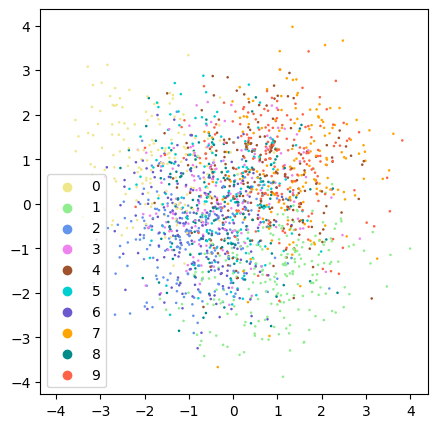

In [14]:
plt.figure(figsize=(5,5))
plt.scatter(*z_reduc, s=0.7, c=[colors[t[0]] for t in t_list])
# 凡例を追加
for i in range(10):
    plt.scatter([],[], c=colors[i], label=i)
plt.legend()

## 階層型VAE

以下にない部分は、通常のVAEと同様です

### デコーダ

In [15]:
class Decoder(nn.Module):
    """
    階層型VAEのデコーダ部分
    （一応通常のVAEでも使用可能）

    latent_dim : 潜在変数の次元
    hidden_dim : 隠れ層の次元
    output_dim : 出力画像の次元
    """
    def __init__(self,
                 latent_dim,
                 hidden_dim,
                 output_dim,
                 use_sigmoid=False
    ):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.use_sigmoid = use_sigmoid

    def forward(self, z):
        """
        use_sigoidを追加
        """
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        if self.use_sigmoid:
            h = F.sigmoid(h)
        return h

### 階層型VAEの実装

In [16]:
# 階層型VAE
class VAE(nn.Module):
    """
    階層型VAE（Hierarchical Variational Autoencoder)

    input_dim : 入力画像の次元
    hidden_dim : 隠れ層の次元
    latent_dim : 潜在変数の次元
    """
    def __init__(self,
                 input_dim,
                 hidden_dim,
                 latent_dim
    ):
        super().__init__()
        self.encoder1 = Encoder(input_dim, hidden_dim, latent_dim)
        self.encoder2 = Encoder(latent_dim, hidden_dim, latent_dim)
        self.decoder1 = Decoder(latent_dim, hidden_dim, input_dim, use_sigmoid=True)
        self.decoder2 = Decoder(latent_dim, hidden_dim, latent_dim)

    def get_loss(self, x):
        """
        L1 : 再構成化誤差
        L2 : KLダイバージェンス
        L3 : 潜在変数の再構成誤差
        """
        mu1, sigma1 = self.encoder1(x)
        z1 = reparameterize(mu1, sigma1)
        mu2, sigma2 = self.encoder2(z1)
        z2 = reparameterize(mu2, sigma2)

        z_hat = self.decoder2(z2)
        x_hat = self.decoder1(z1)

        # loss
        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = - torch.sum(1 + torch.log(sigma2 ** 2) - mu2 ** 2 - sigma2 ** 2)
        L3 = - torch.sum(1 + torch.log(sigma1 ** 2) - (mu1 - z_hat) ** 2 - sigma1 ** 2)
        return (L1 + L2 + L3) / batch_size

### モデルの学習

In [17]:
model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []

for epoch in tqdm(range(epochs), total=epochs):
    loss_sum = 0.0
    cnt = 0

    for x, _ in dataloader:
        x = x.view(x.size(0), -1) # Flatten and move to device
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    print(f"Epoch {epoch+1}, 負のELBO（損失関数）: {loss_avg:.4f}")
    losses.append(loss_avg)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, 負のELBO（損失関数）: 51.5256


### 学習結果の可視化

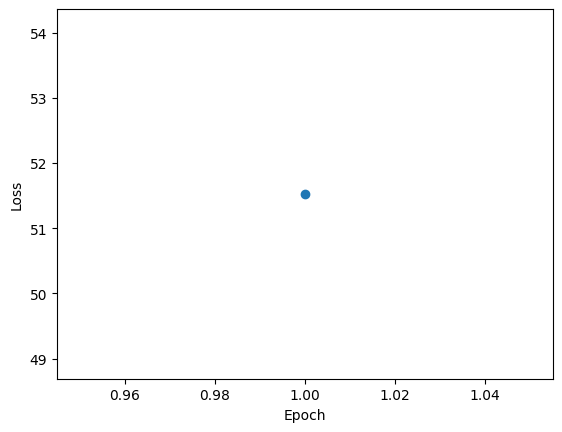

In [18]:
# plot losses
epochs_3 = list(range(1, epochs + 1))
plt.plot(epochs_3, losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

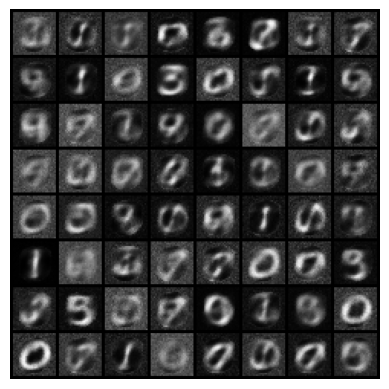

In [19]:
# generate new images
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, latent_dim)
    x = model.decoder1(z)
    generated_images = x.view(sample_size, 1, 28, 28)

grid_img = torchvision.utils.make_grid(generated_images, nrow=8, padding=2, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

### 潜在空間の可視化

  0%|          | 0/1875 [00:00<?, ?it/s]

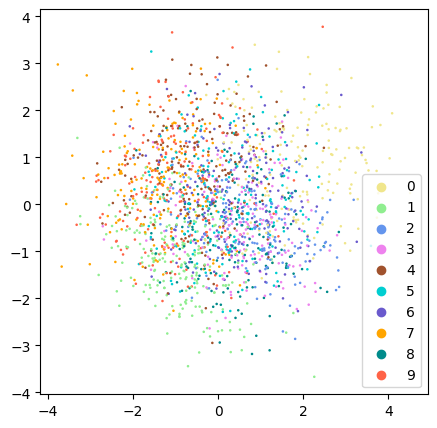

In [20]:
model.eval()
model = model.to(device)

z_list = []
t_list = []
# with torch.no_grad():
for x, t in tqdm(dataloader, total=len(dataloader)):
    t_list.append(t)
    x = x.view(x.size(0), -1).to(device)
    mu, sigma = model.encoder1(x)
    z = reparameterize(mu, sigma)
    z_list.append(z.cpu().detach().numpy()[0])

z_val = np.stack(z_list)

REDUC = 'PCA' # 'TSNE' または 'PCA'
if latent_dim > 2:
    if REDUC == "TSNE":
        z_reduc = TSNE(n_components=2).fit_transform(z_val).T
    elif REDUC == "PCA":
        z_reduc = PCA(n_components=2).fit_transform(z_val).T
    else:
        raise ValueError("Please choose dimensionality reduction method from TSNE or PCA.")
elif latent_dim == 2:
    z_reduc = z_val.T
else:
    raise ValueError("z dimensionality must be larger or equal to 2.")



# 図示
colors = ['khaki', 'lightgreen', 'cornflowerblue', 'violet', 'sienna',
          'darkturquoise', 'slateblue', 'orange', 'darkcyan', 'tomato']

plt.figure(figsize=(5,5))
plt.scatter(*z_reduc, s=0.7, c=[colors[t[0]] for t in t_list])
# 凡例を追加
for i in range(10):
    plt.scatter([],[], c=colors[i], label=i)
plt.legend()

## 埋め込みの例

In [21]:
"""
埋め込みの例（本編には直接関係ないです）
"""
# 10000 -> 300 に埋め込む層
embedding = nn.Embedding(num_embeddings=10000, embedding_dim=300)

# 適当なベクトル（バッチサイズ : 2, 長さ : 5）
input_ids = torch.LongTensor([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]])

# 埋め込み層に入力
embeddings = embedding(input_ids)
print("埋め込みベクトル :\n", embeddings)
print("\n形状 :\n", embeddings.shape)

埋め込みベクトル :
 tensor([[[ 0.2102, -1.3813, -1.8864,  ...,  1.1341,  0.4231,  1.9866],
         [ 0.4805, -1.1787,  0.5903,  ...,  0.2249,  0.4735, -0.6084],
         [ 0.8711,  0.8308, -0.7540,  ...,  1.1803,  1.1111,  0.0397],
         [ 0.2846,  0.1107,  1.8281,  ..., -0.0860, -1.1368, -0.1394],
         [ 1.5162,  2.3410, -0.5136,  ..., -0.8064,  0.5372, -1.2506]],

        [[-0.0482, -0.1336,  1.4576,  ...,  1.4403, -0.3676,  0.1891],
         [-0.1405, -1.3535, -0.7666,  ..., -0.8704, -1.9815,  0.5737],
         [ 0.7205,  1.2679, -0.5085,  ...,  1.3122,  0.7809,  0.1565],
         [-1.2310,  1.5947, -1.3888,  ...,  0.5321, -1.1241,  1.1443],
         [-0.4849,  0.1694, -1.3241,  ..., -0.4447,  0.2827, -0.1511]]],
       grad_fn=<EmbeddingBackward0>)

形状 :
 torch.Size([2, 5, 300])


## VQ-VAE

### （忙しい人のための）ベクトル量子化とは

ベクトル量子化について調べていると, よくネットでは「潜在空間の離散化」といった説明がされますが, 筆者（平井）はなかなか理解ができませんでした.

つまるところ, 以下**順伝播**にあるように, （エンコーダとデコーダの）潜在変数$z$をクラスタリングのように分類してあげる操作, というのをベクトル量子化と呼ぶそうです。

そして, いままでのVAEは 1つのガウス分布からサンプリングしていました. このとき, 例えば「犬と猫の画像を学習させた」とすると, 「1つのガウス分布に犬と猫の両方が分布する」ような, つまり, 「犬と猫は同じものとして分布している」ような, 直感に反する状態下にあります.

ベクトル量子化は, ガウス分布を有限個の潜在変数空間（code book）で近似してあげることで, はっきりと（犬猫などの）カテゴリ間を分類させるところがポイントでしょうか.

<br>

**以下, 松尾研が実施している[深層学習基礎講座（2023）](https://deeplearning.jp/lectures/dlb2023/)の講義資料（第11回）より,
一部引用しております.**

**順伝播**

エンコーダの出力を$z_e$としたとき，デコーダの入力$z_q$としてはembedding space（codebookなどとも呼ばれる）の中からL2ノルムを使用し, $z_e$に最も近いベクトル$e_k$を選択する（つまり, クラスタリングのような操作を行い, 近い潜在変数をとってくる）.


$$
z_q({\bf x}) = e_k, \quad \rm{where} \; k = \rm{argmin}_j || z_e({\bf x}) - e_j ||_2
$$

VAEにおいてガウス分布を仮定していた事後分布 $q(z|{\bf x})$はカテゴリ分布となり，$z$の実現値は以下のようにone-hotベクトルで表される.

$$
q_{\phi}(z = k | {\bf x}) =
\begin{cases}
  1 \quad \rm{for} \; k = \rm{argmin}_j ||z_e ({\bf x}) - e_j||_2 \\
  0 \quad \rm{otherwise}
\end{cases}
$$

デコーダの入力$z_q$をサンプリングする（上記argminを満たす$e_k$を選ぶ）ためには，これとcodebook vectors ${\bf e}$の行列積を計算すれば良い．

<br>

**逆伝播**

順伝播で最も距離が近いベクトルを選ぶ操作（argmin）には勾配が伝わる．VQ-VAEでは，単純に$z_q$の勾配を$z_e$にコピーする（図赤線）．このような勾配の推定量をstraight-through estimatorと呼んだりする．

<br>

**目的関数**

$$
\mathcal{L} = \log p({\bf x} | z_q({\bf x})) + || \rm{sg}[z_e({\bf x})] - e ||_2^2 + \beta || z_e({\bf x}) - \rm{sg}[e] ||_2^2
$$

- VAEと同じく，第1項に再構成誤差がある．

- Straight-through estimatorを用いると，再構成誤差による勾配はembedding space ${\bf e}$を通らなくなる．そのため，第2項によってこれを学習する．

  - $\rm{sg}$はstop gradientのことで，この項によりエンコーダは学習されない（勾配計算しない）ことを意味する．

- 第2項による${\bf e}$の学習が第1項によるエンコーダの学習に追いつかないと，${\bf e}$の学習は発散してしまう可能性がある．それを避けるため，エンコーダの出力が${\bf e}$から離れすぎないようにする正則化項が3つ目にある．

<img src=" 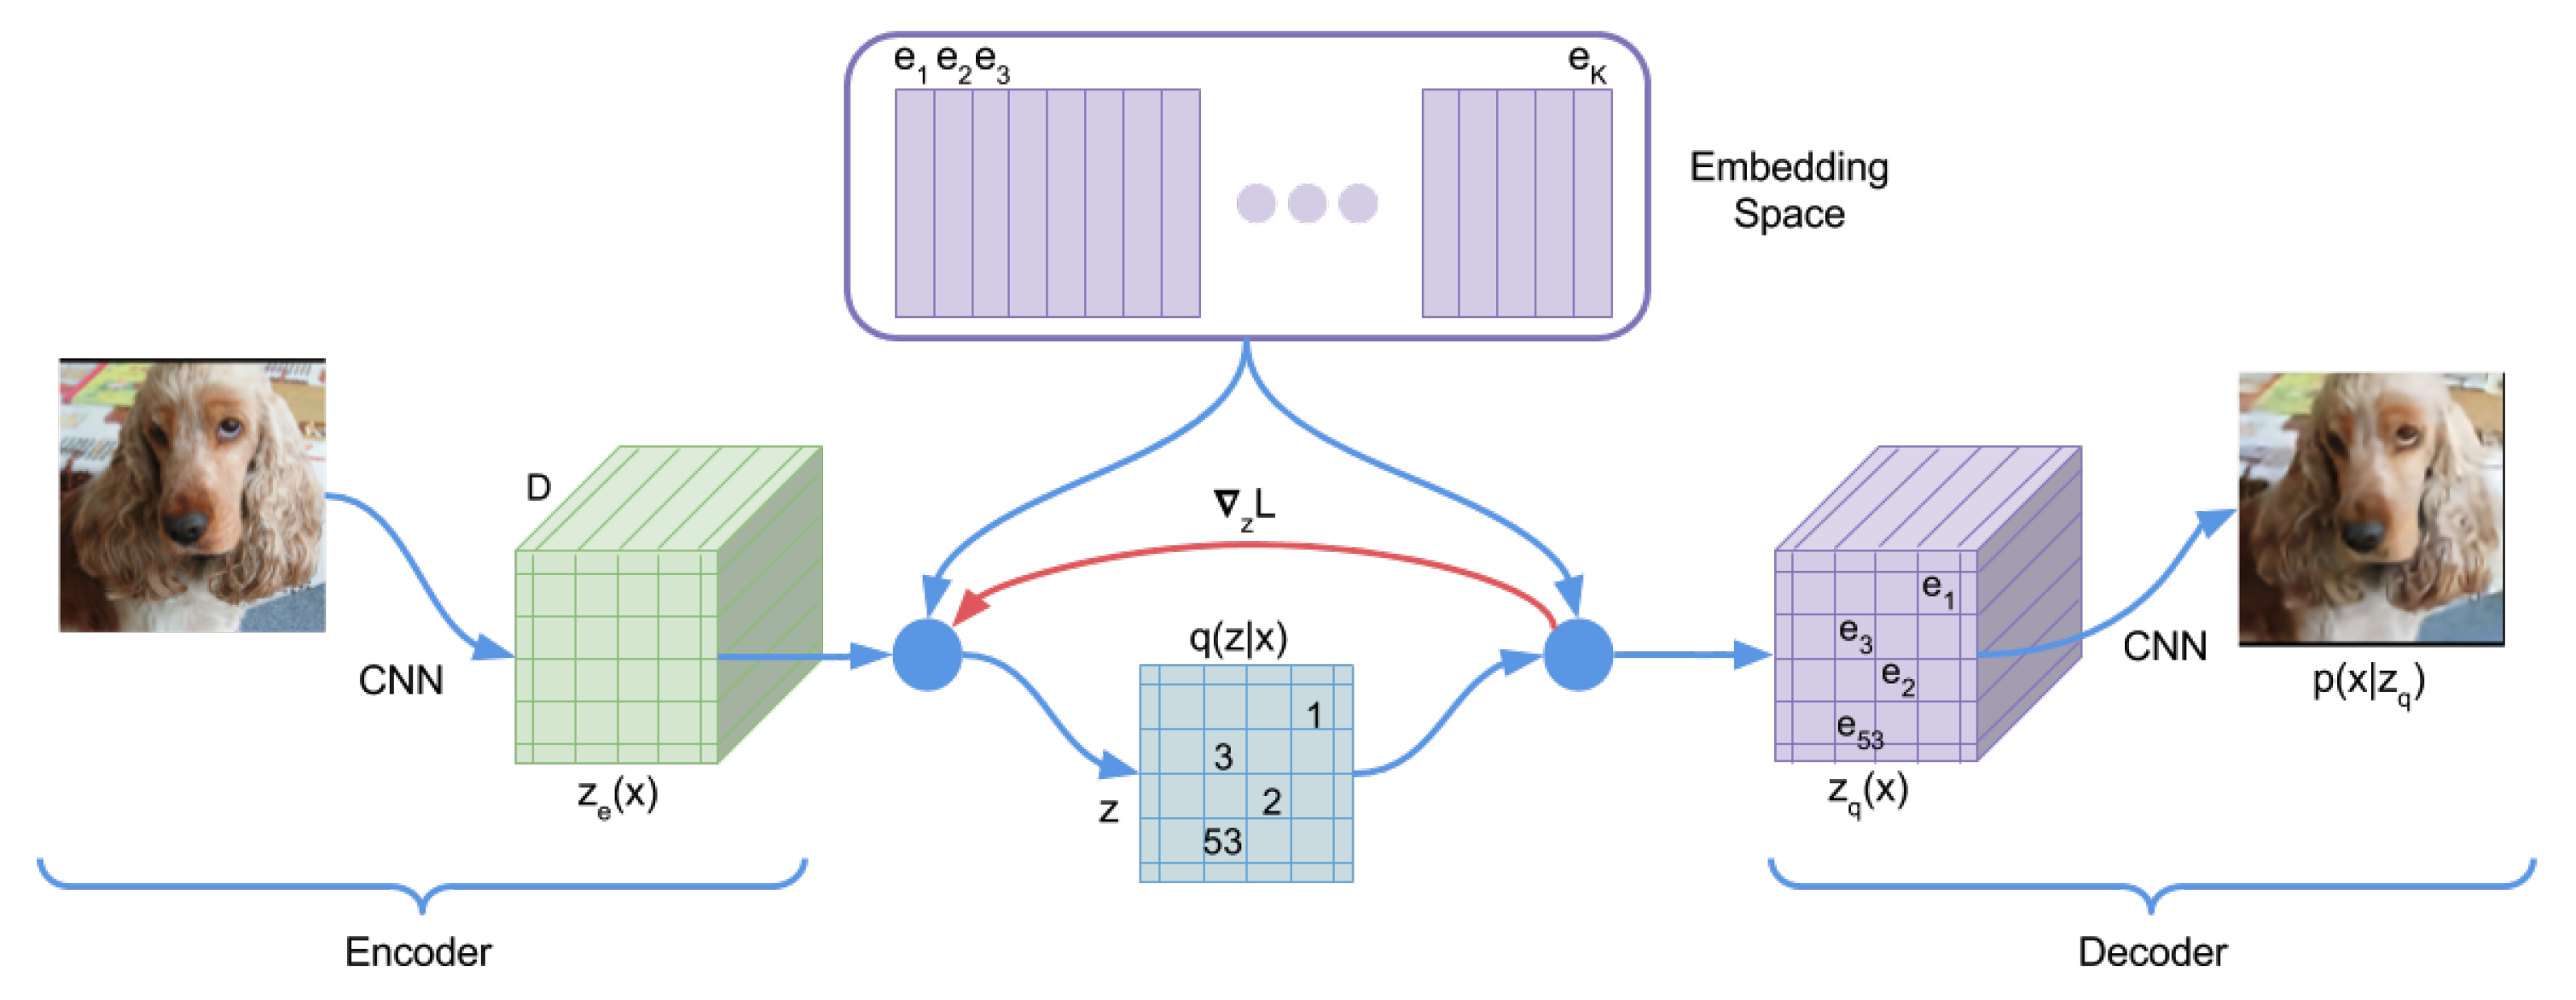" width=80%>

### 量子化のアルゴリズム

In [32]:
class VectorQuantizer(nn.Module):
    """
    潜在空間の離散化（クラスタリング）を行うクラス

    ----------
    num_embeds : int
        Codebook vectors (embedding space)の数．図中のK.
    embed_dim : int
        Codebook vectorsの長さ（embedding spaceの次元数）．
        ．図中のD.
    beta : float
        エンコーダの正則化項の係数．
        目的関数のbeta.
    """
    def __init__(self,
                 num_embeds: int,
                 embed_dim: int,
                 beta: float
    ) -> None:
        super().__init__()

        self.num_embeds = num_embeds
        self.embed_dim = embed_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.num_embeds, self.embed_dim)
        self.embedding.weight.data.uniform_(-1 / self.num_embeds, 1 / self.num_embeds)

    def forward(self, z_e: torch.Tensor) -> Tuple[torch.Tensor]:
        """
        順伝播．

        Parameters
        ----------
        z_e : torch.Tensor ( b, embed_dim, h', w' )
            VQ-VAEのエンコーダの出力（から再パラメータ化したもの、今までのz）

        Returns
        ----------
        loss : torch.Tensor (, )
            目的関数の再構成誤差以外の部分．
        z_q : torch.Tensor ( b, embed_dim, h', w' )
            離散化された潜在変数．
        ----------
        b : バッチサイズ
        h : （画像の）高さ
        w : （画像の）幅
        """
        z_e = z_e.permute(0, 2, 3, 1).contiguous() # (b, embed_dim ,h, w) -> (b, h, w, embed_dim)
        z_e_shape = z_e.shape # (b, h, w, embed_dim)

        z_e_flat = z_e.view(-1, self.embed_dim) # ( b * h * w, embed_dim )

        # L2ノルムの計算
        distances = (
            torch.sum(z_e_flat**2, dim=1, keepdim=True)
            + torch.sum(self.embedding.weight**2, dim=1)
            - 2 * torch.matmul(z_e_flat, self.embedding.weight.T)
        )
        # ( b * h * w, num_embeds )

        # 最も距離の近いembedding vectorのインデックス
        encoding_indices = torch.argmin(distances, dim=1) # ( b * h * w, )

        # 距離の近いベクトルを One-hot Encode
        encodings = F.one_hot(encoding_indices, num_classes=self.num_embeds).to(torch.float32)

        # One-hotベクトルとcodebook vectorsの行列積を取ってquantize
        """
        encodings :
          ( b * h * w, num_embeds )
        self.embedding.weight :
          ( num_embeds, embed_dim )
        z_q :
          ( b * h * w, embed_dim ) -> ( b, h, w, embed_dim )
        """
        z_q = torch.matmul(encodings, self.embedding.weight) # ( b * h * w, embed_dim )
        z_q = z_q.view(z_e_shape) # ( b, h, w, embed_dim )

        # .detach()が目的関数のs.g. (stop gradient)に対応
        e_latent_loss = F.mse_loss(z_q.detach(), z_e)
        q_latent_loss = F.mse_loss(z_q, z_e.detach())
        loss = q_latent_loss + self.beta * e_latent_loss

        # Straight-through estimatorの実装．
        # z_qの順伝播での値を変えないまま，.detach()によってz_e（入力）からz_q
        # までに行ったすべての計算を計算グラフから切り離す．すると，z_qの勾配 = z_eの勾配になる．
        z_q = z_e + (z_q - z_e).detach()

        z_q = z_q.permute(0, 3, 1, 2).contiguous() # ( b, embed_dim, h, w )

        # perplexityは予備の情報．
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return loss, z_q, perplexity

### エンコーダ（畳み込み）

In [37]:
class Encoder(nn.Module):
    """
    VAE のエンコーダ部分（畳み込み）

    input_dim : 入力画像
    hidden_dim : 隠れ層の次元
    latent_dim : 潜在変数の次元
    平均と分散は使わない（離散させる、つまりガウス分布を仮定しないから）
    """
    def __init__(self,
                 input_dim,
                 hidden_dim,
                 latent_dim
    ):
        super().__init__()
        self.ConvEnc1 = nn.Conv2d(input_dim, hidden_dim//2, kernel_size=4, stride=2, padding=1)
        self.ConvEnc2 = nn.Conv2d(hidden_dim//2, hidden_dim, kernel_size=4, stride=2, padding=1)
        self.ConvEnc3 = nn.Conv2d(hidden_dim, latent_dim, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        z_e = self.ConvEnc1(x)
        z_e = F.relu(z_e)
        z_e = self.ConvEnc2(z_e)
        z_e = F.relu(z_e)
        z_e = self.ConvEnc3(z_e)
        return z_e

### デコーダ（最初と同じ）

In [96]:
class Decoder(nn.Module):
    """
    VAE のデコーダ部分（畳み込み）

    embed_dim : 埋め込みの次元

    hidden_dim : 隠れ層の次元
    output_dim : 出力画像の次元
    x_hat : 出力画像
    """
    def __init__(self,
                 embed_dim,
                 hidden_dim,
                 output_dim
    ):
        super().__init__()
        # zを入力にベルヌーイ分布のパラメータlambdaを出力 ( b, embed_dim, h, w ) -> ( b, latent_dim, h, w )
        self.ConvDec1 = nn.Conv2d(embed_dim, hidden_dim, kernel_size=3, stride=1, padding=1)
        # あとは転置畳み込み
        self.ConvDec2 = nn.ConvTranspose2d(hidden_dim, hidden_dim//2, kernel_size=4, stride=2, padding=1)

        # output dim（以下のかっこ内 2番目のパラメータ"1"）は, カラー画像だと 3 にしてください.
        self.ConvDec3 = nn.ConvTranspose2d(hidden_dim//2, 1, kernel_size=4, stride=2, padding=1)

    def forward(self, z_q):
        x_hat = self.ConvDec1(z_q)
        x_hat = F.relu(x_hat)
        x_hat = self.ConvDec2(x_hat)
        x_hat = F.relu(x_hat)
        x_hat = self.ConvDec3(x_hat)
        return x_hat

### VQ-VAEの実装

In [180]:
class VQVAE(nn.Module):
    """
    VQ-VAE（ベクトル量子化変分オートエンコーダ）モデル

    input_dim : 入力画像の次元
    hidden_dim : 隠れ層の次元
    latent_dim : 潜在変数の次元
    embed_dim : コードブックの次元
    num_embeds : コードブックの数
    beta : コードブックの正則化項の係数
    かえり値
    loss : 負のELBO（損失関数）
    """
    def __init__(self,
                 input_dim,
                 hidden_dim,
                 latent_dim,

                 embed_dim,
                 num_embeds,
                 beta
    ):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(embed_dim, hidden_dim, input_dim)

        #  ( b, latent_dim, h, w ) -> ( b, embed_dim, h, w )
        self.pre_vq_conv = nn.Conv2d(
            latent_dim, embed_dim, kernel_size=1, stride=1
        )

        # ベクトル量子化
        self.vq = VectorQuantizer(num_embeds, embed_dim, beta)

    def get_loss(self, x):
        """
        L1 : 再構成化誤差
        L2 : KLダイバージェンス
        """
        z_e = self.encoder(x)
        z_e = self.pre_vq_conv(z_e) # ( b, embed_dim, h, w )

        vq_loss, z_q, perplexity = self.vq(z_e) # z_q : ( b, embed_dim, h, w )

        x_hat = self.decoder(z_q)

        return vq_loss, x_hat, perplexity

### ハイパーパラメータ

In [183]:
# hyperparameters
input_dim = 1
hidden_dim = 16
latent_dim = 64
epochs = 3
learning_rate = 0.001
embed_dim = 32
num_embeds = 64
beta = 0.25
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for data, target in tqdm(dataloader, total=len(dataloader)):
    data_numpy = data.numpy()  # PyTorch TensorをNumPy配列に変換
    data_variance = np.var(data_numpy / 255.0)


  0%|          | 0/1875 [00:00<?, ?it/s]

### モデルの学習

In [184]:
model = VQVAE(input_dim,
              hidden_dim,
              latent_dim,
              embed_dim,
              num_embeds,
              beta
              ).to(device)

losses = []
vq_losses = []
recon_losses = []

for epoch in tqdm(range(epochs), total=epochs):
    epoch_losses = []
    epoch_vq_losses = []
    epoch_recon_losses = []
    cnt = 0

    model.train()
    for x, _ in tqdm(dataloader, total=len(dataloader)):
        x = x.view(-1, 1, 28, 28).to(device)

        vq_loss, x_hat, perplexity = model.get_loss(x)

        # 再構成誤差を計算
        recon_loss = F.mse_loss(x, x_hat) / data_variance

        # 総損失の計算
        loss = recon_loss + vq_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cnt += 1

        # エポック内での損失を記録
        epoch_losses.append(loss.item())
        epoch_vq_losses.append(vq_loss.item())
        epoch_recon_losses.append(recon_loss.item())

    # エポックごとの平均損失を計算
    loss_avg = sum(epoch_losses) / cnt
    vq_loss_avg = sum(epoch_vq_losses) / cnt
    recon_loss_avg = sum(epoch_recon_losses) / cnt

    # 全エポックでの損失を更新
    losses.append(loss_avg)
    vq_losses.append(vq_loss_avg)
    recon_losses.append(recon_loss_avg)

    print(f"Epoch {epoch+1}, 負のELBO（損失関数）: {loss_avg:.4f}")
    print(f"Epoch {epoch+1}, ベクトル量子化損失: {vq_loss_avg:.4f}")
    print(f"Epoch {epoch+1}, 再構成化LOSS : {recon_loss_avg:.4f}")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1, 負のELBO（損失関数）: 74956.7833
Epoch 1, ベクトル量子化損失: 0.0080
Epoch 1, 再構成化LOSS : 74956.7755


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2, 負のELBO（損失関数）: 74956.7832
Epoch 2, ベクトル量子化損失: 0.0080
Epoch 2, 再構成化LOSS : 74956.7754


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3, 負のELBO（損失関数）: 74956.7832
Epoch 3, ベクトル量子化損失: 0.0080
Epoch 3, 再構成化LOSS : 74956.7754


### 学習結果の可視化

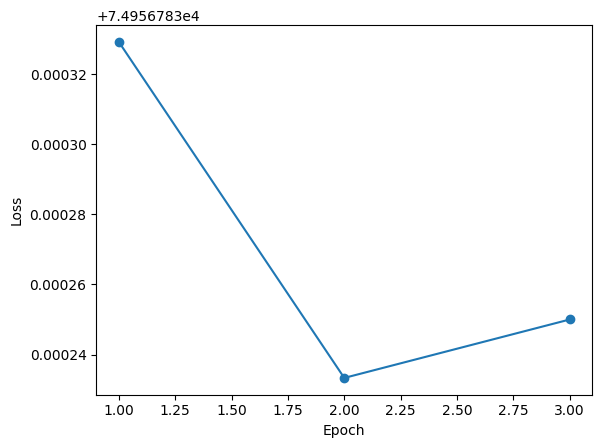

In [185]:
# plot losses
epochs_4 = list(range(1, epochs + 1))
plt.plot(epochs_4, losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

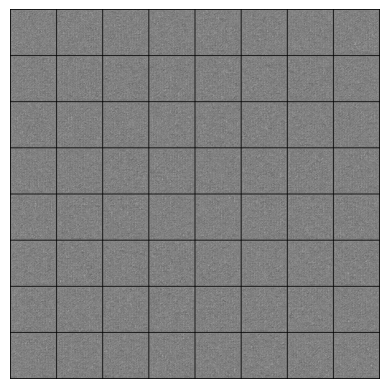

In [186]:
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, embed_dim, 28, 28).to(device)
    x = model.decoder(z)
    generated_images = x

grid_img = torchvision.utils.make_grid(generated_images, nrow=8, padding=2, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()


ただのノイズが生成されました.

これは正常でして, VQ-VAEはガウス分布を仮定しないので, コードブックに無いノイズを与えても, デコーダはノイズを返します.

逆に, 例えばコードブックの潜在変数と, 自然言語を対応させれば, 自然言語に対応する形で, 任意の画像を返すかもしれませんね.

## VQ-VAE 改

In [131]:
class Residual(nn.Module):
    """ Residual Blockの実装 """
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
        num_residual_hiddens: int,
    ) -> None:
        """
        Parameters
        ----------
        in_channels : int
            入力画像のチャンネル数．
        num_hiddens : int
            Convolutional VAEの隠れユニット数．
        num_residual_hiddens : int
            Residual blockの隠れユニット数．
        """
        super().__init__()

        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=num_residual_hiddens,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False
            ),
            nn.ReLU(True),
            nn.Conv2d(
                in_channels=num_residual_hiddens,
                out_channels=num_hiddens,
                kernel_size=1,
                stride=1,
                bias=False
            )
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self._block(x)


class ResidualStack(nn.Module):
    """ Residual Blockを任意の数積み上げる """
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
        num_residual_layers: int = 2,
        num_residual_hiddens: int = 32,
    ) -> None:
        """
        Parameters
        ----------
        num_residual_layers : int
            Residual block数．
        in_channels, num_hiddens, num_residual_hiddensは同上．
        """
        super().__init__()

        self.num_residual_layers = num_residual_layers
        self.layers = nn.ModuleList(
            [
                Residual(in_channels, num_hiddens, num_residual_hiddens)
                for _ in range(self.num_residual_layers)
            ]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for i in range(self.num_residual_layers):
            x = self.layers[i](x)
        return F.relu(x)

In [174]:
class VQVAE(nn.Module):
    """ VQVAEモデルの実装 """
    def __init__(
        self,
        num_hiddens: int,
        num_embeds: int,
        embed_dim: int,
        in_channels: int = 1,
        num_residual_layers: int = 2,
        num_residual_hiddens: int = 32,
        beta: float = 0.25,
    ) -> None:
        """
        Parameters
        ----------
        num_hiddens : int
            Convolutional VAEの隠れユニット数．
        num_embeds : int
            Codebook vectors (embedding space)の数．図中のK.
        embed_dim : int
            Codebook vectorsの長さ（embedding spaceの次元数）．
        in_channels : int
            入力画像のチャンネル数．
        num_residual_layers : int
            Residual block数．
        num_residual_hiddens : int
            Residual blockの隠れユニット数．
        beta : float
            エンコーダの正則化項の係数．目的関数のbeta.
        """
        super().__init__()

        # Encoder, xを入力にガウス分布のパラメータmu, sigmaを出力
        self.conv_enc1 = nn.Conv2d(
            in_channels, num_hiddens//2, kernel_size=4, stride=2, padding=1
        )
        self.conv_enc2 = nn.Conv2d(
            num_hiddens//2, num_hiddens, kernel_size=4, stride=2, padding=1
        )
        self.conv_enc3 = nn.Conv2d(
            num_hiddens, num_hiddens, kernel_size=3, stride=1, padding=1
        )

        # 残差ブロック
        self.residual_enc = ResidualStack(
            in_channels=num_hiddens,
            num_hiddens=num_hiddens,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens
        )

        # Point Wise 畳み込み
        self._pre_vq_conv = nn.Conv2d(
            num_hiddens, embed_dim, kernel_size=1, stride=1
        )

        # ベクトル量子化
        self._vq = VectorQuantizer(num_embeds, embed_dim, beta)

        # Decoder, zを入力にベルヌーイ分布のパラメータlambdaを出力
        self.conv_dec = nn.Conv2d(
            embed_dim, num_hiddens, kernel_size=3, stride=1, padding=1
        )

        # 残差ブロック
        self.residual_dec = ResidualStack(
            in_channels=num_hiddens,
            num_hiddens=num_hiddens,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens
        )

        self.convt_dec1 = nn.ConvTranspose2d(
            num_hiddens, num_hiddens//2, kernel_size=4, stride=2, padding=1
        )
        self.convt_dec2 = nn.ConvTranspose2d(
            num_hiddens//2, 1, kernel_size=4, stride=2, padding=1
        )

    def _encoder(self, x: torch.Tensor) -> torch.Tensor:
        """
        VQ-VAEのエンコーダ部分．

        Parameters
        ----------
        x : torch.Tensor ( b, c, h, w )
            入力画像（flattenされていない）．

        Returns
        ----------
        z : torch.Tensor ( b, num_hiddens, h', w' )
            Encoderの出力．次に_pre_vq_convに通すことでz_eに対応
        """
        z = F.relu(self.conv_enc1(x))
        z = F.relu(self.conv_enc2(z))
        z = self.conv_enc3(z)

        z = self.residual_enc(z)

        return z

    def _decoder(self, z: torch.Tensor) -> torch.Tensor:
        """
        VQ-VAEのデコーダ部分．

        Parameters
        ----------
        z : torch.Tensor ( b, embed_dim, h', w' )
            離散化された潜在変数．z_qに対応

        Returns
        ----------
        x : torch.Tensor ( b, c, h, w )
            再構成画像．
        """
        x = self.conv_dec(z)

        x = self.residual_dec(x)

        x = F.relu(self.convt_dec1(x))
        x = self.convt_dec2(x)

        return x

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        順伝播．

        Parameters
        ----------
        x : torch.Tensor ( b, c, h, w )
            入力画像（flattenされていない）．

        Returns
        ----------
        loss : torch.Tensor (, )
            目的関数の再構成誤差以外の部分．
        x : torch.Tensor ( b, c, h, w )
            再構成画像．
        perplexity : torch.Tensor ( b, z_dim )
            潜在変数．
        """
        z_e = self._encoder(x) # ( b, num_hiddens, h', w' )

        z_e = self._pre_vq_conv(z_e) # ( b, embed_dim, h', w' )

        loss, z_q, perplexity = self._vq(z_e)
        # (, ), ( b, embed_dim, h', w' ), (, )

        x = self._decoder(z_q)

        return loss, x, perplexity

### モデルの学習

In [175]:
n_epochs = 3
losses = []
vq_losses = []
recon_losses = []

model = VQVAE(num_hiddens=128, num_embeds=512, embed_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in tqdm(range(n_epochs), total = n_epochs):
    epoch_losses = []
    epoch_vq_losses = []
    epoch_recon_losses = []
    cnt = 0

    model.train()
    for x, _ in tqdm(dataloader, total = len(dataloader)):

        x = x.view(-1, 1, 28, 28).to(device)
        # x = x.to(device)

        vq_loss, x_recon, perplexity = model(x)

        # ここで再構成誤差を計算．
        recon_loss = F.mse_loss(x, x_recon) / data_variance

        loss = recon_loss + vq_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cnt += 1

        epoch_losses.append(loss.cpu().detach().numpy())
        epoch_vq_losses.append(vq_loss.cpu().detach().numpy())
        epoch_recon_losses.append(recon_loss.cpu().detach().numpy())

    # エポックごとの平均損失を計算
    loss_avg = sum(epoch_losses) / cnt
    vq_loss_avg = sum(epoch_vq_losses) / cnt
    recon_loss_avg = sum(epoch_recon_losses) / cnt

    # 全エポックでの損失を更新
    losses.append(loss_avg)
    vq_losses.append(vq_loss_avg)
    recon_losses.append(recon_loss_avg)
    print(f"Epoch {epoch+1}, 負のELBO（損失関数）: {loss_avg:.4f}")
    print(f"Epoch {epoch+1}, ベクトル量子化損失: {vq_loss_avg:.4f}")
    print(f"Epoch {epoch+1}, 再構成化LOSS : {recon_loss_avg:.4f}")


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1, 負のELBO（損失関数）: 3027212740.0794
Epoch 1, ベクトル量子化損失: 3027187999.2686
Epoch 1, 再構成化LOSS : 24738.9414


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2, 負のELBO（損失関数）: 467509654.0416
Epoch 2, ベクトル量子化損失: 467496557.3205
Epoch 2, 再構成化LOSS : 13096.9980


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3, 負のELBO（損失関数）: 258835082.5856
Epoch 3, ベクトル量子化損失: 258822476.0277
Epoch 3, 再構成化LOSS : 12606.3307


### 学習結果の可視化

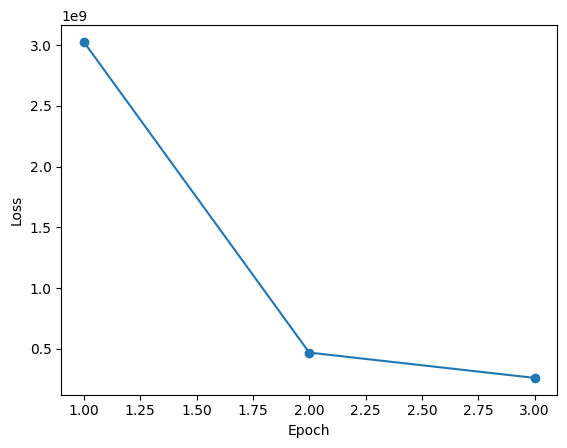

In [176]:
# plot losses
epochs_5 = list(range(1, n_epochs + 1))
plt.plot(epochs_5, losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

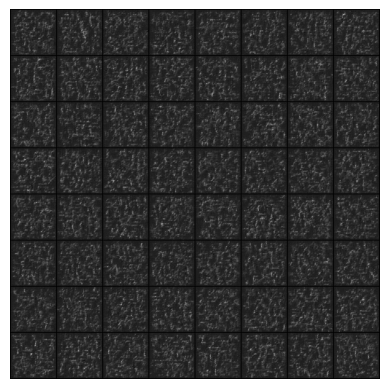

In [179]:
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, 64, 28, 28).to(device)
    x = model._decoder(z)
    generated_images = x #.view(sample_size, 1, 28, 28)

grid_img = torchvision.utils.make_grid(generated_images, nrow=8, padding=2, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()


## 参考になりそうなサイト

- https://data-analytics.fun/2022/01/27/pytorch-vq-vae/